
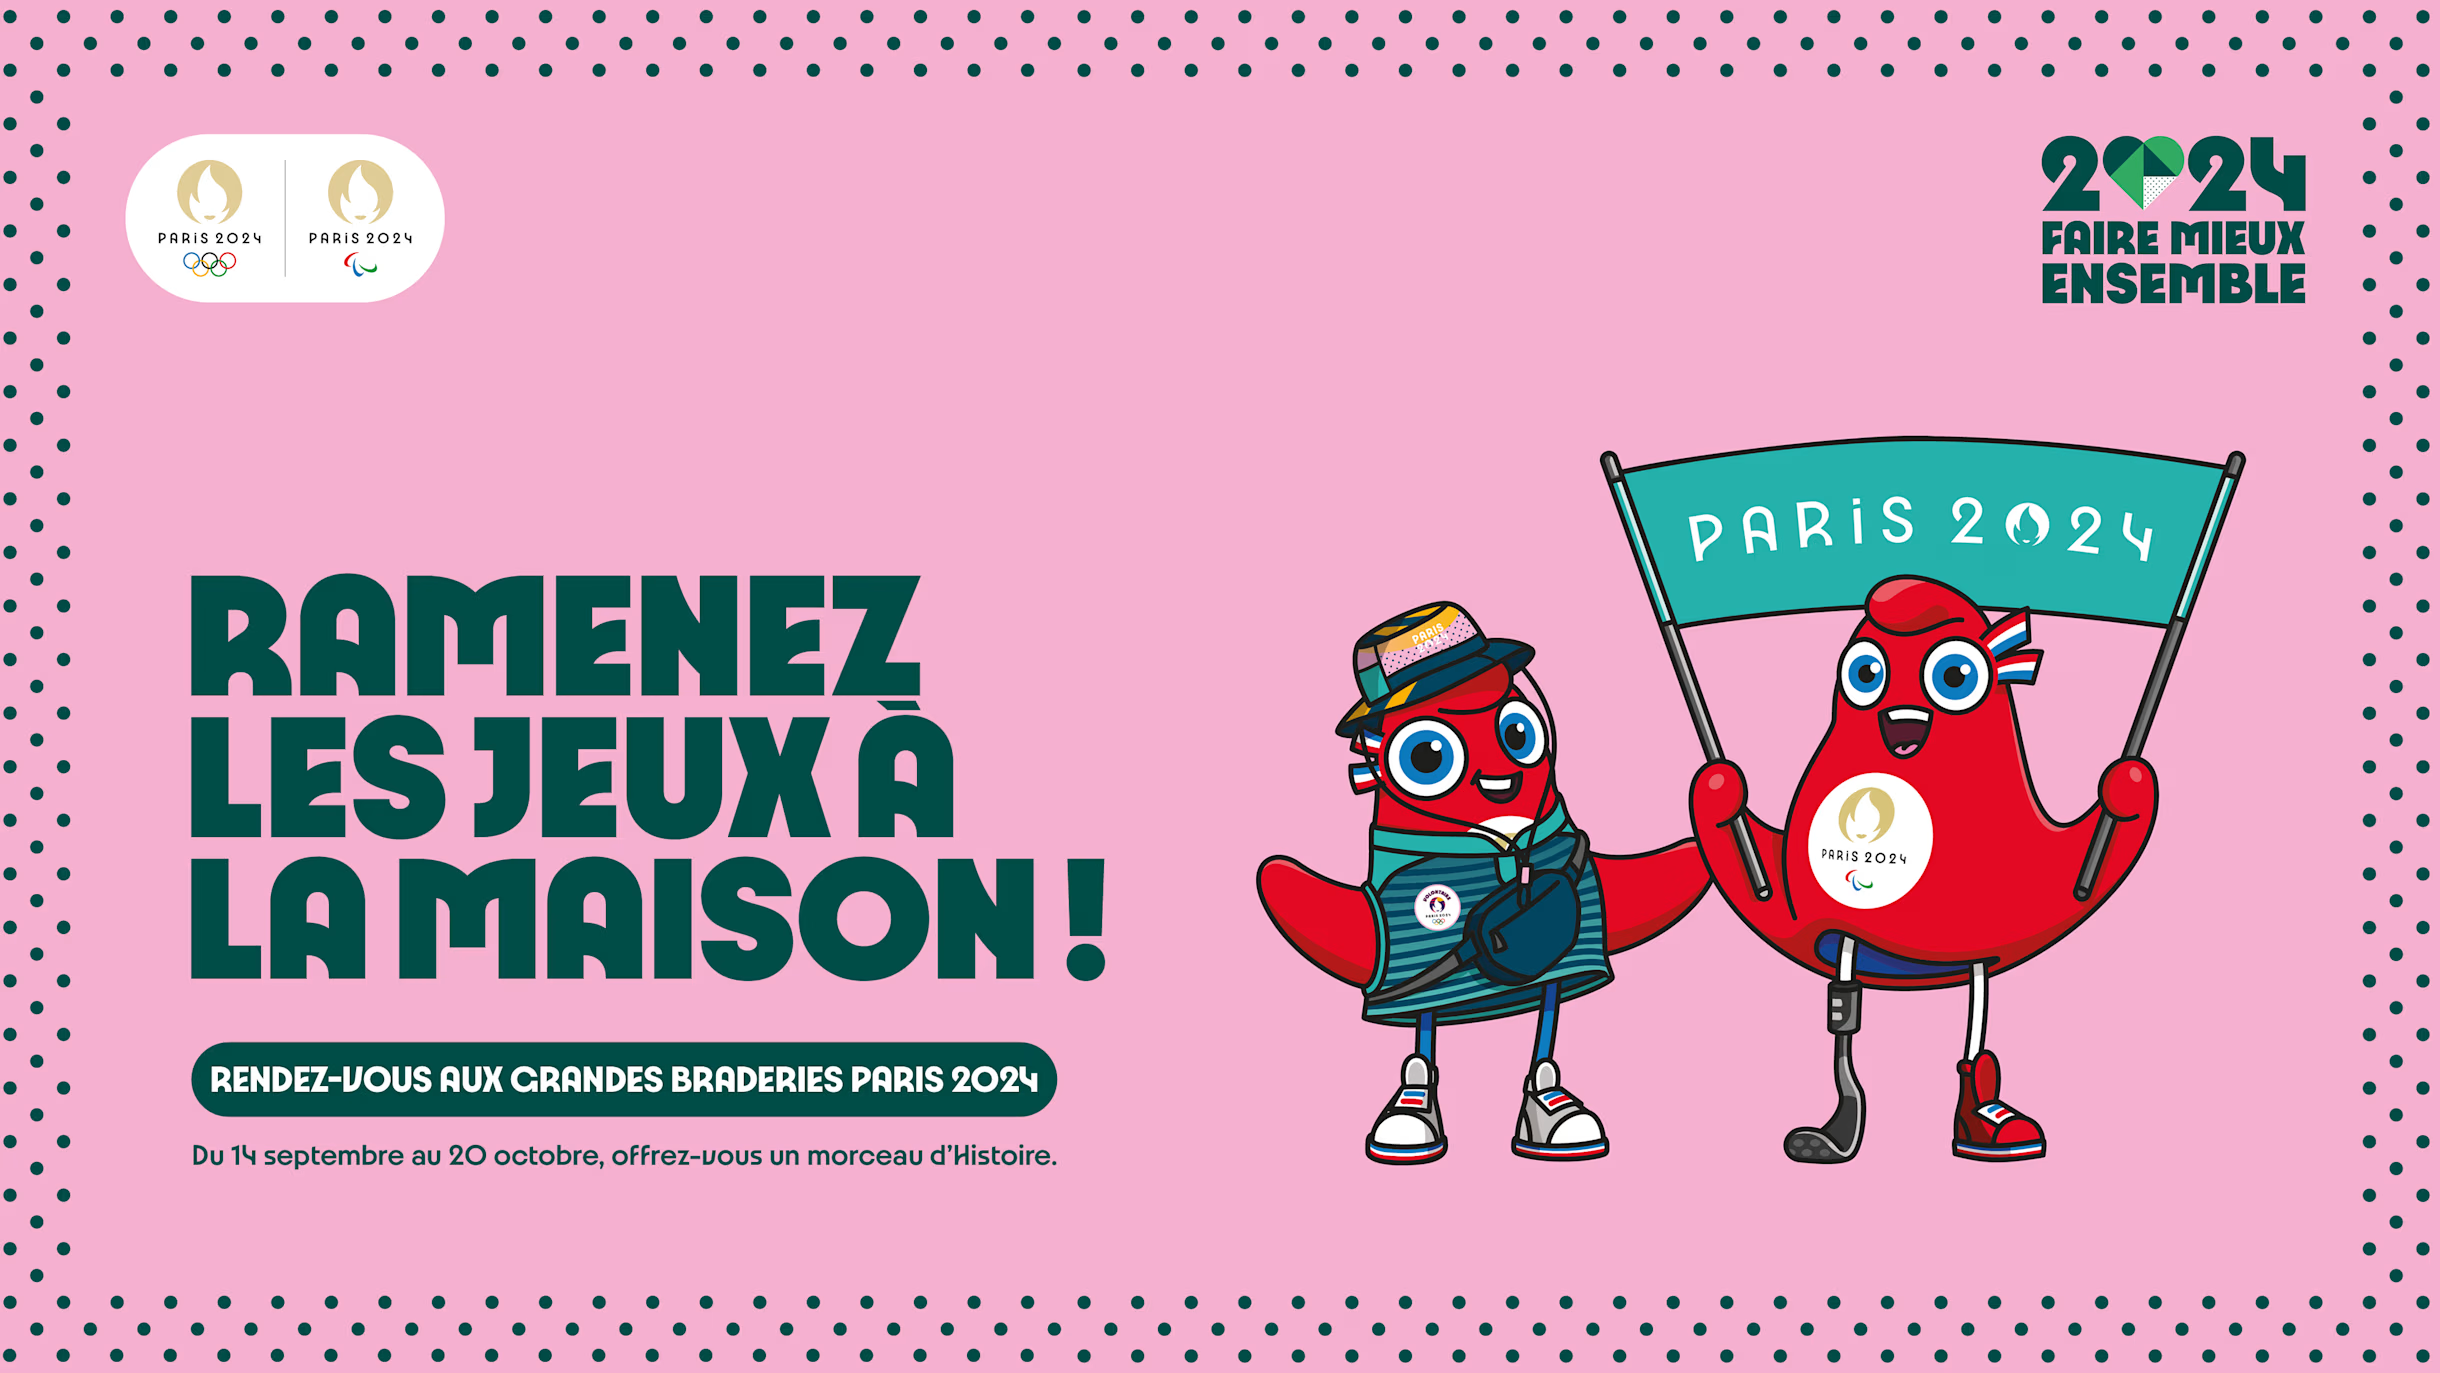


# 🏅 RAG Olympics - Building an AI-Powered Q&A System!

## 🎯 Welcome to the RAG Challenge!

In this hands-on project, you'll build a **Retrieval-Augmented Generation (RAG)** system that can answer questions about the Olympics!

---

### 🤔 What is RAG?

**RAG = Retrieval + Generation**

Think of it like having a super-smart assistant with access to a library:

```
User Question → 📚 Find Relevant Documents → 🤖 LLM Generates Answer
```

**The Magic:** Instead of relying only on the LLM's training data, we give it **real-time access to specific information**!

---

### 🎓 What You'll Learn:

| Step | What | Why |
|------|------|-----|
| 1️⃣ | **Load Data** | Get Olympics FAQ documents |
| 2️⃣ | **Create Embeddings** | Convert text to vectors |
| 3️⃣ | **Build Vector DB** | Store for fast similarity search |
| 4️⃣ | **Retrieval** | Find relevant documents |
| 5️⃣ | **Prompt Engineering** | Craft effective prompts |
| 6️⃣ | **Generate Answers** | Use LLM with context |

---

### 🌟 Why RAG is useful ?

✅ **Up-to-date info:** Add new knowledge without retraining  
✅ **Grounded answers:** Responses based on your documents  
✅ **Reduced hallucinations:** LLM has concrete context  
✅ **Transparent sources:** Can cite which documents were used  
✅ **Cost-effective:** No need to fine-tune large models  

---

### 🏗️ System Architecture:

```
┌─────────────────────────────────────────────────────────┐
│                      RAG PIPELINE                       │
├─────────────────────────────────────────────────────────┤
│                                                         │
│  1. INDEXING PHASE (One-time setup)                     │
│     ┌──────────┐    ┌──────────┐    ┌──────────┐        │
│     │ Documents│ -> │Embeddings│ -> │ Vector DB│        │
│     └──────────┘    └──────────┘    └──────────┘        │
│                                                         │
│  2. QUERY PHASE (Real-time)                             │
│     ┌─────────┐   ┌──────────┐   ┌──────────┐   ┌─────┐ │
│     │ Question│ ->│ Search DB│ ->│  Context │ ->│ LLM │ │
│     └─────────┘   └──────────┘   └──────────┘   └─────┘ │
│                                                     ↓   │
│                                               ┌────────┐│
│                                               │ Answer ││
│                                               └────────┘│
└─────────────────────────────────────────────────────────┘
```

Let's build it! 🚀

---

## 📄 Step 1: Loading the Olympics FAQ Data

We'll work with a JSON file containing frequently asked questions about the Olympics.

### 📊 Data Structure:

```json
[
  {
    "id": "OnlOaClN-fr",
    "lang": "fr",
    "label": "Comment acheter des billets pour...",
    "body": "Des billets pour les Jeux Olympiques...",
    "topics": "Billetterie et Hospitalité...", 
    "url": "https://help.paris2024.org/contents..."
  },
  ...
]
```

Let's load and explore the data!

In [ ]:
# Load the FAQ data
from pathlib import Path
import json

# Get the notebook's directory
notebook_dir = Path.cwd()
data_path = notebook_dir / "data" / "paris-2024-faq.json"
with open(data_path, "r") as f:
    faq_data = json.load(f)

print(f"✅ Loaded {len(faq_data)} FAQ entries!\n")

In [ ]:
# Display first entry
faq_data[0]

In [ ]:
# Filter to keep only English documents
faq_data_en = [item for item in faq_data if item["lang"] == "en"]

In [ ]:
# Display sample entries
print("📋 Sample FAQ Entries:\n")
for i, entry in enumerate(faq_data_en[:3], 1):
    print(f"{i}. Q: {entry['label']}")
    print(f"   A: {entry['body'][:100]}...\n")

print(f"💡 Total entries: {len(faq_data_en)}")

---

## 🔄 Step 2: Preprocessing - Creating LangChain Documents

### Why Create Documents?

LangChain uses a special `Document` object that:
- 📝 Stores the text content
- 🏷️ Includes metadata (source, category, etc.)
- 🔍 Works seamlessly with vector stores

First get familiar with this object

In [ ]:
from langchain_core.documents import Document

# The LangChain Document object contains 2 attributes:
# - a page_content attribute: stores the main text content
# - a metadata attribute: stores additional information about the document


# Creating a sample Document object
document = Document(
    page_content="Hello, world!", metadata={"source": "https://example.com"}
)

# Display the document
print(document)

In [ ]:
document.page_content

In [ ]:
document.metadata

### Our Strategy:

We'll combine each Q&A pair into a single document:
```
"Question: [question]\nAnswer: [answer]"
```

This helps the retrieval system find relevant Q&A pairs based on user questions!

In [ ]:
print("🔄 Creating LangChain Document objects...\n")

# Convert FAQ entries to LangChain Documents
documents = []

for entry in faq_data_en:
    # Combine question and answer into one document
    content = f"Question: {entry['label']}\nAnswer: {entry['body']}"

    # Create Document with metadata
    doc = Document(
        page_content=content,
        metadata={
            "source": "Olympics FAQ",
            "faq_id": entry["id"],
            "question": entry["label"],
            "answer": entry["body"],
            "topics": entry["topics"],
            "url": entry["url"],
        },
    )

    documents.append(doc)

print(f"✅ Created {len(documents)} Document objects!\n")

# Show an example document
print("📄 Example Document Structure:\n")
print(f"Content (first 200 chars):\n{documents[0].page_content[:200]}...\n")
print(f"Metadata:\n{documents[0].metadata}")

print("\n💡 These documents are now ready for embedding!")

---

## 🧠 Step 4: Creating the Vector Database

This is where the magic happens! We'll:
1. Convert documents to embeddings (vectors)
2. Store them in a Qdrant vector database
3. Enable lightning-fast similarity search

---

### 🎯 What is Qdrant?

**Qdrant** (read: quadrant) is a vector similarity search engine and database:
- ⚡ **Fast:** High-performance search with advanced filtering capabilities
- 💪 **Powerful:** Production-ready with built-in scalability and clustering
- 🎨 **Flexible:** Supports payloads, filtering, and multiple distance metrics
- 🆓 **Open Source:** Free to use with both in-memory and persistent storage options
- 🐳 **Cloud-Native:** Easy deployment with Docker, Kubernetes, or managed cloud service
- 🚀 **Versatile Deployment:**
  - **In-Memory:** Perfect for development and testing
  - **Docker:** Quick local setup with containerization
  - **Local:** Run natively on your machine for production
  - **Cloud:** Managed service (Qdrant Cloud) for scalability

---

### 🔤 Embedding Model:

We'll use **text-embedding-3-small**:
- 📊 1536-dimensional vectors (default)
- Max input: 8192 tokens
- ⚡ Fast encoding speed
- 🎯 Great for semantic search
- 🌐 Works well in multiple languages

In [ ]:
from dotenv import load_dotenv

load_dotenv()

# Initialize the embedding model
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    # With the `text-embedding-3` class
    # of models, you can specify the size
    # of the embeddings you want returned.
    # dimensions=1024
)

In [ ]:
print("🧠 Step 5: Creating Vector Database\n")
print("=" * 60)

print("\n📊 Step 5.1: Loading embedding model...")
print("   Model: text-embedding-3-small")
print("   This creates 1536-dimensional vectors\n")

# Initialize the embedding model

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    # With the `text-embedding-3` class
    # of models, you can specify the size
    # of the embeddings you want returned.
    # dimensions=1024
)
print("✅ Embedding model loaded!\n")

## See documentation here https://docs.langchain.com/oss/python/integrations/text_embedding/openai

In [ ]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams


# client = QdrantClient(path=local_output)
# In memory client:
COLLECTION_NAME = "olympics-2024"
# VECTOR_NAME = "sparse-embedding" # this is to asspciate a name with the embedding
EMBEDDING_SIZE = len(embeddings.embed_query("hello"))

# instanciate the in memory client
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=EMBEDDING_SIZE, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    embedding=embeddings,
    collection_name=COLLECTION_NAME,
    # vector_name=VECTOR_NAME,
)

# See documentation https://reference.langchain.com/python/integrations/langchain_qdrant/

In [ ]:
from uuid import uuid4

ids = [str(uuid4()) for _ in range(len(documents))]
vector_store.add_documents(documents=documents, ids=ids)


print("✅ Documents added to the Vector database!\n")

---

## 🔍 Step 5: Testing the Retrieval System

Let's test our vector database by searching for relevant documents!

### How Retrieval Works:

```
User Query → Embed Query → Find Similar Vectors → Return Documents
```

The system uses **cosine similarity** to find the most relevant documents!

In [ ]:
print("🔍 Testing the Retrieval System\n")
print("=" * 60)

# Test query
test_query = "How do I get disabled parking spaces?"

print(f"❓ User Query: '{test_query}'\n")
print("🔄 Searching vector database...\n")

# Retrieve top 3 most relevant documents
retrieved_docs = vector_store.similarity_search(
    query=test_query, k=3  # Return top 3 matches
)

print(f"✅ Found {len(retrieved_docs)} relevant documents!\n")
print("📄 Retrieved Documents:\n")

for i, doc in enumerate(retrieved_docs, 1):
    print(f"{'='*60}")
    print(f"Document {i}:")
    print(f"{'='*60}")
    print(f"Content:\n{doc.page_content}\n")
    # print(f"Metadata: {doc.metadata}\n")

print("💡 Notice:")
print("   • The system found the most relevant Q&A pairs!")
print("   • Documents are ranked by semantic similarity")
print("   • This context will help the LLM answer accurately")

In [ ]:
# TODO: Try to Enhance retrieval quality
# - Find a way to Retrieve cosine similarity scores for each search result [See documentation here https://qdrant.tech/documentation/core/concepts/query_vector/]
# - Experiment with higher k values to return more candidate documents
# - Implement a similarity threshold to filter low-relevance results

---

## 🎨 Step 6: Formatting Documents for the Prompt

We need to format our retrieved documents as a single string to pass them as context to the LLM prompt.

### Strategy:

Format each document as:
```
Document 1:
[content]

Document 2:
[content]
...
```

This makes it easy for the LLM to reference specific documents!

In [ ]:
def format_docs(docs):
    """
    Format retrieved documents for inclusion in prompt

    Args:
        docs: List of Document objects

    Returns:
        Formatted string with numbered documents
    """
    formatted = []

    for i, doc in enumerate(docs, 1):
        formatted.append(f"Document {i}:\n{doc.page_content}")

    return "\n\n".join(formatted)


# Test the formatting
print("🎨 Document Formatting Example:\n")
print("=" * 60)

formatted_context = format_docs(retrieved_docs[:2])  # Show first 2
print(formatted_context)

print("\n" + "=" * 60)
print("✅ Formatting function created!")
print("💡 This clean format helps the LLM understand the context")

In [ ]:
def format_docs_alternative(docs):
    """
    Format retrieved documents for inclusion in prompt

    Args:
        docs: List of Document objects

    Returns:
        Formatted string with numbered documents
    """
    formatted = []

    # TODO: Optimize context format
    # - Experiment with answer-only context (vs current question+answer)
    #   Rationale: Question aids embedding quality, but may be redundant for LLM
    # - Add source URLs from metadata for response citations and transparency

    for i, doc in enumerate(docs, 1):
        formatted.append(
            f"Document {i}:\n{doc.metadata['answer']}\nSource: {doc.metadata['url']}"
        )

    return "\n\n".join(formatted)


# Test the formatting
print("🎨 Document Formatting Example:\n")
print("=" * 60)

formatted_context = format_docs_alternative(retrieved_docs[:2])  # Show first 2
print(formatted_context)

print("\n" + "=" * 60)
print("✅ Formatting function created!")
print("💡 This clean format helps the LLM understand the context")

💡Notice how there are repeated lines and multiple line breaks - we should have preprocessed this data as well! 
Keep these optimization ideas in mind for improving the RAG system in the next exercise, which will be a bit more challenging! 😊

---

## 📝 Step 8: Crafting the Prompt

### Why Prompts Matter:

A well-crafted prompt is like giving clear instructions to a smart assistant. It should:
- 🎯 **Be specific:** Clear about what to do
- 📚 **Provide context:** Give relevant information
- 🚫 **Set boundaries:** What NOT to do
- ✅ **Be structured:** Easy for LLM to parse

---

### Our Prompt Strategy:

```
SYSTEM ROLE → CONTEXT (Documents) → USER QUESTION → INSTRUCTIONS
```

In [ ]:
print("📝 Creating the RAG Prompt Template\n")
print("=" * 60)

# Define the prompt template
prompt_template = """You are a helpful assistant answering questions about the Olympic Games.

Use the following context documents to answer the user's question. If the answer is not in the provided documents, say "I don't have that information in the provided documents."

Context Documents:
{context}

User Question: {question}

Instructions:
1. Answer based ONLY on the provided documents
2. Be specific and cite which document(s) you used
3. If information is unclear or missing, say so
4. Keep answers concise but complete
5. Use a friendly, informative tone
Answer:"""

---

## 🤖 Step 9: Initialize the LLM

**GPT-5 nano** is optimized for fast, cost-effective responses:

| Feature | Details | Why It Matters for RAG |
|---------|----------|----------------------|
| **Speed** | ⚡ Very fast | Quick responses to user queries |
| **Context Window** | 400K tokens | Fits many retrieved documents |
| **Max Output** | 128K tokens | Detailed answers possible |
| **Cost** | Ultra-affordable | Scalable for production use |
| **Strengths** | Summarization & classification | Perfect for synthesizing retrieved context |

The ideal choice for production RAG systems! 🎯

In [ ]:
MODEL_NAME = "gpt-5-nano"
REASONING_EFFORT = "minimal"  # could be   "minimal" | "low" | "medium" | "high"  see [https://platform.openai.com/docs/guides/latest-model]
TEMPERATURE = 0

In [ ]:
print("🤖 Initializing the Language Model\n")
print("=" * 60)
# Initialize the LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model=MODEL_NAME, temperature=TEMPERATURE, reasoning_effort=REASONING_EFFORT
)

# try an invoke
response = llm.invoke("hello")
print("response to hello:", response.content)

print("\n✅ LLM initialized successfully!")

---

## 🎯 Step 10: Building the Complete RAG Pipeline

Now let's put it all together! We'll create a function that:
1. Takes a user question
2. Retrieves relevant documents
3. Formats them into a prompt
4. Gets an answer from the LLM

This is the **complete RAG pipeline**! 🚀

In [ ]:
def make_rag_prompt(question, k=3):
    """
    Create a RAG prompt by retrieving relevant documents

    Args:
        question: User's question
        k: Number of documents to retrieve

    Returns:
        Formatted prompt string with context and question
    """
    # Step 1: Retrieve relevant documents
    retrieved_docs = vector_store.similarity_search(query=question, k=k)

    # Step 2: Format documents
    context = format_docs(retrieved_docs)

    # Step 3: Fill in the prompt template
    full_prompt = prompt_template.format(context=context, question=question)

    return full_prompt

In [ ]:
question = "when are the olympics ?"
print(make_rag_prompt(question, k=3))

In [ ]:
def rag_assistant(user_question, k=3, verbose=False):
    """
    Complete RAG pipeline: question → retrieval → generation

    Args:
        user_question: The question to answer
        k: Number of documents to retrieve
        verbose: Whether to print intermediate steps

    Returns:
        LLM's answer string
    """
    if verbose:
        print("🔄 RAG Pipeline Steps:\n")
        print(f"1️⃣  Query: '{user_question}'")
        print(f"2️⃣  Retrieving top {k} documents...")

    # Create the prompt with retrieved context
    full_prompt = make_rag_prompt(user_question, k=k)

    if verbose:
        print(f"3️⃣  Prompt created ({len(full_prompt)} characters)")
        print(f"4️⃣  Generating answer with LLM...\n")

    # Get answer from LLM
    response = llm.invoke(full_prompt)

    return response.content


print("✅ RAG Pipeline Functions Created!\n")

---

## 🎮 Step 11: Testing the RAG System!

Let's ask some questions and see our RAG system in action! 🚀

### Test Questions:

We'll test with various types of questions to see how well our system performs.

In [ ]:
print("🎮 Testing the RAG System\n")
print("=" * 70)

# Test Question 1
question1 = "What can I do if i'm disabled?"

print(f"\n❓ Question 1: {question1}\n")
print("🤖 RAG Assistant's Answer:\n")
print(rag_assistant(question1, verbose=False, k=5))
print("\n" + "=" * 70)

In [ ]:
# Test Question 2
question2 = "How many days ?"

print(f"\n❓ Question 2: {question2}\n")
print("🤖 RAG Assistant's Answer:\n")
print(rag_assistant(question2))
print("\n" + "=" * 70)

In [ ]:
# Test Question 3
question3 = "Who are the guests for the ceremony ?"

print(f"\n❓ Question 3: {question3}\n")
print("🤖 RAG Assistant's Answer:\n")
print(rag_assistant(question3))
print("\n" + "=" * 70)

In [ ]:
# Test Question 4 - Testing edge case (not in documents)
question4 = "What are the specifities of the 2024 olympics ?"

print(f"\n❓ Question 4 (Edge Case): {question4}\n")
print("🤖 RAG Assistant's Answer:\n")
print(rag_assistant(question4))
print("\n" + "=" * 70)

print("\n💡 Notice: When information isn't in the documents,")
print("   the system correctly says it doesn't have that information!")
print("   This prevents hallucinations. ✅")

---

## 🎨 Step 12: Interactive Q&A Session with Gradio

Now it's your turn! Ask your own questions about the Olympics!

In [ ]:
import gradio as gr

K = 5


def rag_assistant_response(message, history):
    return rag_assistant(message, k=K, verbose=False)


gr.ChatInterface(fn=rag_assistant_response).launch()

---

## 📊 Step 14: RAG System Analysis

Let's analyze our RAG system's performance and characteristics.

---

## 💡 Step 15: Understanding RAG Performance

### 🎯 What Makes a Good RAG System?

| Metric | Good | Excellent | Why It Matters |
|--------|------|-----------|----------------|
| **Retrieval Accuracy** | 70-80% | 90%+ | Finding the right documents |
| **Answer Quality** | Relevant | Precise & cited | Useful to users |
| **Response Time** | <2s | <1s | User experience |
| **Hallucination Rate** | <10% | <5% | Trustworthiness |

---

### 🔧 Ways to Improve RAG:

1. **Better Chunking**
   - Optimal chunk size (100-500 tokens)
   - Semantic chunking (not just character count)
   - Overlap between chunks

2. **Improved Retrieval**
   - Hybrid search (keyword + semantic)
   - Reranking retrieved documents
   - Query expansion/reformulation

3. **Better Embeddings**
   - Domain-specific embedding models
   - Fine-tuned embeddings
   - Multi-vector approaches

4. **Prompt Engineering**
   - Clear instructions
   - Few-shot examples
   - Chain-of-thought reasoning

5. **Advanced Techniques**
   - Self-querying retrieval
   - Hypothetical document embeddings (HyDE)
   - Multi-query retrieval

---

## 🎉 Congratulations!

You've successfully built a complete RAG system! Here's what you accomplished:

## 📚 Skills Acquired:

✅ **Data Preparation**
   - Loading and structuring documents
   - Creating LangChain Document objects
   - Preprocessing for RAG

✅ **Embeddings & Vector Search**
   - Converting text to embeddings
   - Building Qdrant vector databases
   - Performing similarity search

✅ **Prompt Engineering**
   - Crafting effective RAG prompts
   - Context formatting
   - Instruction design

✅ **LLM Integration**
   - Using ChatOpenAI API
   - Model configuration
   - Response generation

✅ **System Design**
   - Building end-to-end pipelines
   - Performance optimization

---

---

## 💭 Final Thoughts

<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 25px; border-radius: 15px; margin: 20px 0;">
    <h3 style="margin-top: 0;">🎓 Remember:</h3>
    <p><strong>"The best RAG system is the one that solves your specific problem."</strong></p>
    <ul>
        <li>Start simple and iterate</li>
        <li>Measure what matters to your users</li>
        <li>Focus on retrieval quality first</li>
        <li>Then optimize generation</li>
        <li>Always test with real users</li>
    </ul>
</div>

---

<div style="text-align: center; background: linear-gradient(135deg, #FF6B6B 0%, #FFE66D 100%); padding: 30px; border-radius: 15px; margin: 30px 0;">
    <h2 style="margin: 0; font-size: 2.5em;">🏅 You're Now a RAG Expert!</h2>
    <p style="margin: 20px 0 0 0; font-size: 1.3em; font-weight: bold;">Go forth and build amazing AI-powered systems! 🚀</p>
</div>

---

### 📚 Additional Resources:

- [LangChain Documentation](https://python.langchain.com/)
- [RAG Best Practices](https://www.anthropic.com/research)

### 🤝 Community:

- LangChain Discord
- r/MachineLearning
- AI Stack Exchange
- Hugging Face Forums

---

**Happy Building! 🎉**